In [15]:
from scipy.signal import fftconvolve, convolve2d
from scipy.ndimage.filters import gaussian_filter
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis
from scipy.ndimage import label, find_objects
from scipy.ndimage.filters import maximum_filter
%matplotlib inline

In [16]:
#simulation = "/scratch/datasets/meerkat16_deep2like/"
#simulation = "/scratch/datasets/meerkat16_deep2like_morerange/"
#simulation = "/scratch/datasets/meerkat16_deep2like_morerange_512/"
simulation = "/scratch/gijs/datasets/meerkat16_oleg/flux100/"

In [17]:
#neural_output = "/scratch/vacuum-cleaner/test/meerkat16_deep2like/fits/"   #  2.834
#neural_output = "/scratch/vacuum-cleaner/test/meerkat16_deep2like_sphe_noscale/fits/"   # 2.7635
#neural_output = "/scratch/vacuum-cleaner/test/meerkat16_deep2like_allblack/fits/"  # 2.8523
#neural_output = "/scratch/vacuum-cleaner/test/meerkat16_deep2like_morerange/fits/"  # 3.99
#neural_output = "/scratch/vacuum-cleaner/test/meerkat16_deep2like_morerange_withscale/fits/" # 3.135590717989963
#neural_output = "/scratch/vacuum-cleaner/test/meerkat16_deep2like_map/fits/"  # 2.48
#neural_output = "/scratch/vacuum-cleaner/test/meerkat16_deep2like_madandgan/fits/"  #  2.44
#neural_output = "/scratch/vacuum-cleaner/test/meerkat16_deep2like_mad_scale_l1_100/fits/"  # 30000: 2.48 50000: 2.52
#neural_output = "/scratch/vacuum-cleaner/test/meerkat16_deep2like_madandgan_nopsf/fits/"  # 2.77
#neural_output = "/scratch/vacuum-cleaner/test/meerkat16_deep2like_madandgan_verylong/fits/"  # 2.56
#neural_output = "/scratch/vacuum-cleaner/test/meerkat16_deep2like_madandganandl1_verylong/fits/"  # 2.43
#neural_output = "/scratch/vacuum-cleaner/test/meerkat16_deep2like_res100_l1-200_gan1/fits/" # 2.39, 2.169 with peak
#neural_output = "/scratch/vacuum-cleaner/test/meerkat16_deep2like_res100_l1-200_gan1_l0-1/fits/"  # 2.56
#neural_output = "/scratch/vacuum-cleaner/test/meerkat16_3800train_deep2like_res30_l1-200_gan1_l0-0.001_512/fits/"  # 10.000 - 2.86, 30.000 - 2.7, 2.3 with peak
#neural_output = "/scratch/vacuum-cleaner/test/generative/fits/"  # 4.1
#neural_output = "/scratch/vacuum-cleaner/test/generative_separable_conv/fits/"  # 3.11
#neural_output = "/scratch/vacuum-cleaner/test/meerkat16_3800train_deep2like_res30_l1-200_gan1_l0-0.001_noscale_blur/fits/" # 3.0
#neural_output = "/scratch/vacuum-cleaner/test/generative_blur/fits/"  #  3.18
#neural_output = "/scratch/vacuum-cleaner/test/generative_blur_1pxgauss/fits/"  #  3.22
#neural_output = "/scratch/vacuum-cleaner/test/generative_scale/fits/" # 2.0187
#neural_output = "/scratch/vacuum-cleaner/test/generative_scale_flux1000/fits/" #  10K: 2.16 15K: 2.16 20K: 2.13 30K: 2.29 100K: 2.42 
#neural_output = "/scratch/gijs/vacuum-cleaner/test/landman_flux10_100Kiter/fits/"  # 2.37
#neural_output = "/scratch/gijs/vacuum-cleaner/test/landman_flux10_30Kiter/fits/"  # 2.36
#neural_output = "/scratch/gijs/vacuum-cleaner/test/landman_flux1000_100Kiter/fits/" # 2.36
#neural_output = "/scratch/gijs/vacuum-cleaner/test/baseline_flux10_75Kiter/fits/" # 2.48
#neural_output = "/scratch/gijs/vacuum-cleaner/test/baseline_flux100_75Kiter/fits/" # # 2.48
#neural_output = "/scratch/gijs/vacuum-cleaner/test/baseline_flux100_26Kiter/fits/" # 2.24
#neural_output = "/scratch/gijs/vacuum-cleaner/test/landman_outputl1_flux100_68Kiter/fits/" # 2.21
#neural_output = "/scratch/gijs/vacuum-cleaner/test/landman_outputl1_flux100_100Kiter/fits/" # 2.24
#neural_output = "/scratch/gijs/vacuum-cleaner/test/landman_outputl1_flux100_30Kiter/fits/" #  2.15
#neural_output = "/scratch/gijs/vacuum-cleaner/test/landman_outputl1_flux100_gan10_30Kiter/fits/"  # 2.111
neural_output = "/scratch/gijs/vacuum-cleaner/test/landman_likelihood/fits/"  # 2.10
neural_output = "/scratch/gijs/vacuum-cleaner/test/landman_likelihood_noscale_56Kiter/fits/" # 3.85
neural_output = "/scratch/gijs/vacuum-cleaner/test/landman_likelihood_noscale_30Kiter/fits/" # 2.81

In [18]:
##more range
#start = 3800
#end = 4000

##flux1000
start = 1000
end = 2000

In [19]:
def render(a, imgdata, title):
    i = a.pcolor(imgdata, cmap='cubehelix')
    f.colorbar(i, ax=a)
    a.set_title(title)
    
def open_fits(x):
    return fits.open(x)[0].data.squeeze()

def blur(m):
    return gaussian_filter(m, sigma=1)

def rms(x):
    return np.sqrt(np. mean(x**2))

def l0(x):
    return np.sum(x == 0)

def find_peaks(data, size=3):
    peaks = np.zeros(data.shape)
    data_max = maximum_filter(data, size=3)
    labeled, num_objects = label(data_max)
    slices = find_objects(labeled)
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        y_center = (dy.start + dy.stop - 1)/2    
        peaks[int(y_center), int(x_center)] = data_max[int(y_center), int(x_center)]
    return peaks

In [20]:
std_wsclean = []
std_neural = []

l1_wsclean = []
l1_neural = []

l0_wsclean = []
l0_neural = []

for number in range(start, end):
    target_path = "{}{}-skymodel.fits".format(simulation, number)
    neural_model_path = "{}{}-outputs.fits".format(neural_output, number)
    wsclean_model_path = "{}{}-wsclean-model.fits".format(simulation, number)
    
    neural_residual_path = "{}{}-residuals.fits".format(neural_output, number)
    wsclean_residual_path = "{}{}-wsclean-residual.fits".format(simulation, number)
    
    dirty_path = "{}{}-wsclean-dirty.fits".format(simulation, number)
    
    residual_wsclean = open_fits(wsclean_residual_path)
    residual_neural = open_fits(neural_residual_path)
    
    target = open_fits(target_path)
    dirty = open_fits(dirty_path)
    neural_model = find_peaks(open_fits(neural_model_path))
    wsclean_model = open_fits(wsclean_model_path)
    
    if np.isnan(residual_wsclean).any():
        print("wsclean nan value " + str(number))
        continue
    
    if np.isnan(residual_neural).any():
        print("vacuum nan value " + str(number))
        continue
        
    l0_neural.append(l0(neural_model))
    l0_wsclean.append(l0(wsclean_model))
    
    l1_neural.append(np.sum(np.abs( neural_model - target)))
    l1_wsclean.append(np.sum(np.abs( wsclean_model - target)))
      
    std_wsclean.append(rms(residual_wsclean))
    std_neural.append(rms(residual_neural))

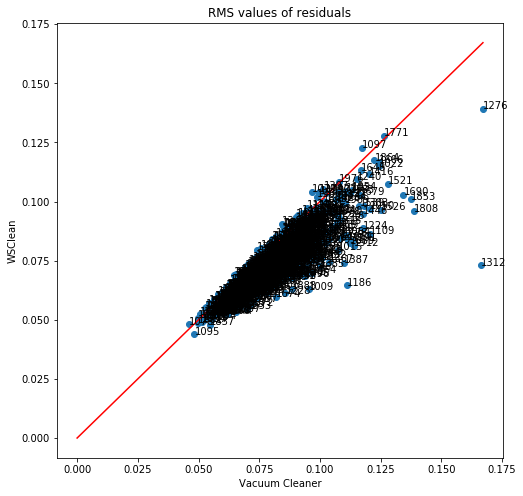

In [21]:
m = max(std_wsclean + std_neural)
f, (a1) = plt.subplots(1, 1, figsize=(8,8))
a1.plot(std_neural, std_wsclean, 'o')
a1.plot([0, m], [0, m], 'r-')
a1.set_xlabel('Vacuum Cleaner')
a1.set_ylabel('WSClean')
a1.set_title('RMS values of residuals')

#a1.set_aspect('equal')

for i, txt in enumerate(range(start, end)):
   a1.annotate(txt, (std_neural[i], std_wsclean[i]))

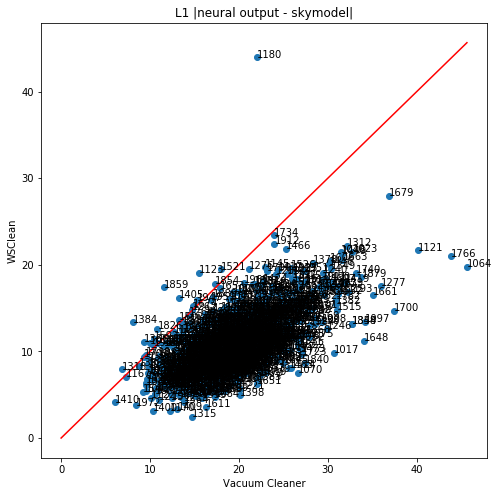

In [22]:
m = max(l1_wsclean + l1_neural)
f, (a1) = plt.subplots(1, 1, figsize=(8,8))
a1.plot(l1_neural, l1_wsclean, 'o')
a1.plot([0, m], [0, m], 'r-')
a1.set_xlabel('Vacuum Cleaner')
a1.set_ylabel('WSClean')
a1.set_title('L1 |neural output - skymodel|')

for i, txt in enumerate(range(start, end)):
    a1.annotate(txt, (l1_neural[i], l1_wsclean[i]))

Text(0.5, 1.0, 'L0 model')

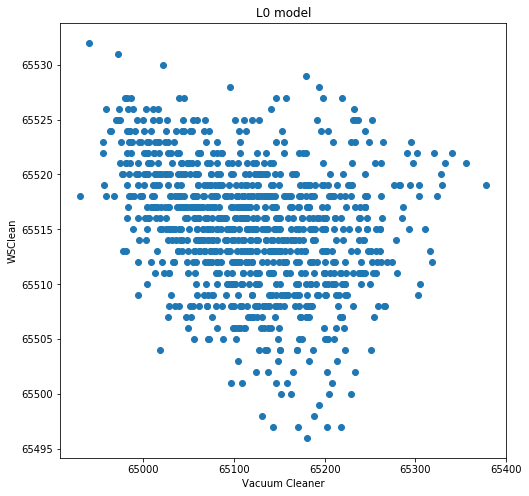

In [23]:
f, (a1) = plt.subplots(1, 1, figsize=(8,8))
a1.plot(l0_neural, l0_wsclean, 'o')
a1.set_xlabel('Vacuum Cleaner')
a1.set_ylabel('WSClean')
a1.set_title('L0 model')

In [24]:
sum(l1_neural), np.average(l1_neural), np.mean(l1_neural)

(18978.005812605315, 18.978005812605378, 18.978005812605378)

In [25]:
l1_scaling = 1/ np.average(l1_wsclean)
std_scaling = 1/ np.average(std_wsclean)

In [26]:
np.average(l1_wsclean) * l1_scaling + np.average(std_wsclean) * std_scaling   # should be 2.0

2.0

In [27]:
# this is our weighted scoring function, higher is worse, 2.0 is wsclean
np.average(l1_neural) * l1_scaling + np.average(std_neural) * std_scaling

2.815629923020558

In [28]:
number = 2806
target_path = "{}{}-skymodel.fits".format(simulation, number)
neural_model_path = "{}{}-outputs.fits".format(neural_output, number)
wsclean_model_path = "{}{}-wsclean-model.fits".format(simulation, number)
neural_residual_path = "{}{}-residuals.fits".format(neural_output, number)
wsclean_residual_path = "{}{}-wsclean-residual.fits".format(simulation, number)
dirty_path = "{}{}-wsclean-dirty.fits".format(simulation, number)

residual_wsclean = open_fits(wsclean_residual_path)
residual_neural = open_fits(neural_residual_path)
target = open_fits(target_path)
dirty = open_fits(dirty_path)
neural_model = open_fits(neural_model_path)
wsclean_model = open_fits(wsclean_model_path)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/gijs/datasets/meerkat16_oleg/flux100/2806-wsclean-residual.fits'

In [ ]:
f, ((a1, a2), (a3, a4), (a5, a6)) = plt.subplots(3, 2, figsize=(14,16))
render(a1, dirty, 'dirty')
render(a2, target, 'skymodel')
render(a3, wsclean_model, 'wsclean_model')
render(a4, residual_wsclean, 'residual_wsclean')
render(a5, neural_model, 'neural_model')
render(a6, residual_neural, 'residual_neural')